We're going to create a Generative Pre-trained Transformer in JAX. More specifically we're going with GPT2 architecture which is a decoder-only transformer. We'll be heavily following the tutorial here: https://huggingface.co/blog/sachithgunasekara/nanojaxgpt

Starting hard with the implementation of the SwiGLU activation function which is a variant of GLU.

GLU can dynamically adjust non-linearity based on the specific training task ?? Have to understand better.

https://azizbelaweid.substack.com/p/what-is-swiglu-how-to-implement-it

![Firefox 2024-10-28 15.28.05.png](<attachment:Firefox 2024-10-28 15.28.05.png>)
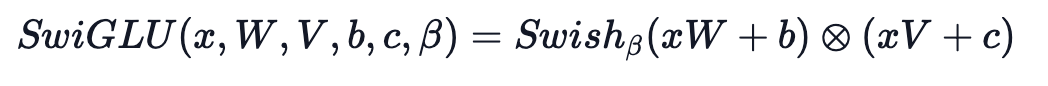

In [2]:
import jax
import equinox as eqx
import equinox.nn as nn
import jax.numpy as np

class SwiGLU(eqx.Module):
    W: nn.Linear
    V: nn.Linear
    b: jax.Array
    c: jax.Array

    def __init__(self, input_dim, output_dim, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.W = nn.Linear(input_dim, output_dim, key=key1)
        self.V = nn.Linear(input_dim, output_dim, key=key2)
        self.b = jax.random.normal(key3, (output_dim))
        self.c = jax.random.normal(key4, (output_dim))
        

    def __call__(self, x):
        return jax.nn.swish((self.W(x) + self.b) * (self.V(x) + self.c))


In [3]:
key = jax.random.PRNGKey(69)
mod = SwiGLU(10, 4, key)

x = np.ones(10)
print(mod(x).shape)

(4,)


In [4]:
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int = 128
    vocab_size: int = 50304  # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 3
    n_head: int = 3
    n_embd: int = 200
    dropout: float = 0.0
    bias: bool = False  #

In [5]:

class MLP(eqx.Module):
    layers: list


    def __init__(self, config, key):

        key1, key2, key3 = jax.random.split(key, 3)

        self.layers = [
            nn.Linear(config.n_embd, 4 * config.n_embd, use_bias=config.bias, key=key1),
            SwiGLU( 4 * config.n_embd,  4 * config.n_embd, key=key2),
            nn.Linear(4 * config.n_embd, config.n_embd, use_bias=config.bias, key=key3),
            nn.Dropout(config.dropout)
        ]
# TODO: Interesting take on the fact that vmap should be applied here ?
    def __call__(self, x):
        y = x
        for layer in self.layers:
            y = layer(y)

        return y

In [6]:
class MLPTheirs(eqx.Module):
    c_fc: eqx.nn.Linear
    swiglu: SwiGLU
    c_proj: eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, config, key):
        lkey1, lkey2, skey = jax.random.split(key, 3)

        self.c_fc = eqx.nn.Linear(config.n_embd, 4 * config.n_embd, use_bias=config.bias, key=lkey1)
        self.swiglu = SwiGLU(4 * config.n_embd, 4 * config.n_embd, skey)
        self.c_proj = eqx.nn.Linear(4 * config.n_embd, config.n_embd, use_bias=config.bias, key=lkey2)
        self.dropout = eqx.nn.Dropout(config.dropout)

    def __call__(self, x):
        x = jax.vmap(self.c_fc)(x)
        x = jax.vmap(self.swiglu)(x)
        x = jax.vmap(self.c_proj)(x)
        x = self.dropout(x)
        return x

In [7]:
config= GPTConfig()
key = jax.random.PRNGKey(69)

mlp = MLP(config,key)
mlp_theirs = MLPTheirs(config,key)

x = jax.random.normal(key, (100, config.n_embd))

res = mlp(x)
res_theirs = mlp_theirs(x)

average_diff = np.mean(res_theirs)
print(average_diff)

TypeError: dot_general requires contracting dimensions to have the same shape, got (200,) and (100,).

In [8]:
import math

class CausalSelfAttention(eqx.Module):
    attnk: nn.Linear
    attnq: nn.Linear
    attnv: nn.Linear
    proj: nn.Linear
    
    resid_dropout: nn.Dropout
    attn_dropout: nn.Dropout

    mask: jax.Array = eqx.field(static=True)
    
    def __init__(self, config, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        
        self.attnk = nn.Linear(config.n_embd,  config.n_embd, use_bias=config.bias, key=key1)
        self.attnv = nn.Linear(config.n_embd, config.n_embd, use_bias=config.bias, key=key2)
        self.attnq = nn.Linear(config.n_embd,  config.n_embd, use_bias=config.bias, key=key3)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        
        self.proj = nn.Linear(config.n_embd,  config.n_embd, use_bias=config.bias, key=key4)

        self.mask = np.tril(np.ones((config.block_size, config.block_size)))

    # Could play arround with the different attention score calculations (Baidhu ?)
    # X is an embedding, it should self attend.  
    
    def __call__(self, x):
        # x = np.swapaxes(x, -1, -2)
        T, C = x.shape # Seq length and embedding dim.
        

        q = jax.vmap(self.attnq)(x)
        k = jax.vmap(self.attnk)(x)
        v = jax.vmap(self.attnv)(x)
        
        att = np.matmul(q, np.transpose(k)) / math.sqrt(np.shape(k)[-1])
        att = np.where(jax.numpy.equal(jax.lax.stop_gradient(self.mask[:T, :T]), 0), float('-inf'), att)
        att = jax.nn.softmax(att, axis=-1)
        att = self.attn_dropout(att)

        y = np.matmul(att, v)

        y = jax.vmap(self.proj)(y)
        y = self.resid_dropout(y)
        return y

In [ ]:
config= GPTConfig()
key = jax.random.PRNGKey(69)

mlp = CausalSelfAttention(config,key)
print(mlp(jax.random.normal(key, (100, config.n_embd))).shape)

In [42]:
class Block(eqx.Module):
    norm: nn.LayerNorm
    attn: CausalSelfAttention
    mlp: MLP

    def __init__(self, config, key):
        key1, key2 = jax.random.split(key, 2)
        
        self.norm = nn.LayerNorm(config.n_embd, use_bias=config.bias)
        self.attn = CausalSelfAttention(config, key=key1)
        self.mlp = MLP(config, key=key2)
        

    def __call__(self, x):
        y = jax.vmap(self.norm)(x)
        y = self.attn(y) # Can't vmap as the whole point is exchange info between tokens.
        x = y + x

        y = jax.vmap(self.norm)(x)
        y = jax.vmap(self.mlp)(y)
        x = y + x

        return x

In [43]:
class BlockTheirs(eqx.Module):
    ln_1: eqx.nn.LayerNorm
    attn: CausalSelfAttention
    ln_2: eqx.nn.LayerNorm
    mlp: MLP

    def __init__(self, config, key):
        ckey, mkey = jax.random.split(key, 2)

        self.ln_1 = eqx.nn.LayerNorm(config.n_embd, use_bias=config.bias)
        self.attn = CausalSelfAttention(config, ckey)
        self.ln_2 = eqx.nn.LayerNorm(config.n_embd, use_bias=config.bias)
        self.mlp = MLPTheirs(config, mkey)

    def __call__(self, x):
        x = x + self.attn(jax.vmap(self.ln_1)(x))
        x = x + self.mlp(jax.vmap(self.ln_2)(x))
        return x

In [44]:
config= GPTConfig()
key = jax.random.PRNGKey(69)

mlp = Block(config,key)
mlp_theirs = BlockTheirs(config,key)

x = jax.random.normal(key, (100, config.n_embd))

res = mlp(x)
res_their = mlp_theirs(x)

average_diff = np.mean(res-res_their)
print(average_diff)

0.0


/tmp/ipykernel_516935/3826073895.py:10: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.attn = CausalSelfAttention(config, key=key1)
/tmp/ipykernel_516935/2198360038.py:11: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.attn = CausalSelfAttention(config, ckey)


All the three main parts that consitute the last part, the block have been coded, we can proceed to the actual model.

In [11]:
class TransformerLayer(eqx.Module):
    wte: nn.Embedding # Token embeddings
    wpe: nn.Embedding # Positional embeddings

    drop: nn.Dropout

    layers: list
    norm: nn.LayerNorm

    def __init__(self, config, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)

        self.wte = nn.Embedding(config.vocab_size, config.n_embd, key=key1)
        self.wpe = nn.Embedding(config.block_size, config.n_embd, key=key2)
        self.drop = nn.Dropout(config.dropout)

        self.layers = [Block(config, key) for _ in range(config.n_layer)]
        self.norm = nn.LayerNorm(config.n_embd, use_bias=config.bias)

    def __call__(self, token_ids):
        (t,)= token_ids.shape
        
        # Should use better positional embeddings with cos and sin.
        pos = np.arange(0, t, dtype=np.int64)

        tok_emb = jax.vmap(self.wte)(token_ids)
        pos_emb = jax.vmap(self.wpe)(pos)

        # Dropout at the first layer ? Seems a bit aggressive...
        x = self.drop(tok_emb + pos_emb)
        
        for block in self.layers:
            x = block(x)
        x = jax.vmap(self.norm)(x)

        return x

In [9]:
class TransformerLayerTheirs(eqx.Module):
    _config: GPTConfig = eqx.field(static=True)

    wte: eqx.nn.Embedding
    wpe: eqx.nn.Embedding
    drop: eqx.nn.Dropout
    h: list
    ln_f: eqx.nn.LayerNorm

    def __init__(self, config, key):
        ekey, pkey, hkey, fkey = jax.random.split(key, 4)

        assert config.vocab_size is not None
        assert config.block_size is not None
        self._config = config

        self.wte = eqx.nn.Embedding(config.vocab_size, config.n_embd, key=ekey)
        self.wpe = eqx.nn.Embedding(config.block_size, config.n_embd, key=pkey)
        self.drop = eqx.nn.Dropout(config.dropout)
        self.h = [Block(config, hkey) for _ in range(config.n_layer)]
        self.ln_f = eqx.nn.LayerNorm(config.n_embd, use_bias=config.bias)

    def __call__(self, idx):
        t, = idx.shape
        assert t <= self._config.block_size, f"Cannot forward sequence of length {t}, block size is only {self._config.block_size}"
        pos = np.arange(0, t, dtype=np.int64)

        tok_emb = jax.vmap(self.wte)(idx)  # token embeddings of shape (t, n_embd)
        pos_emb = jax.vmap(self.wpe)(pos)  # position embeddings of shape (t, n_embd)
        x = self.drop(tok_emb + pos_emb)
        for block in self.h:
            x = block(x)
        x = jax.vmap(self.ln_f)(x)

        return x


In [51]:
config= GPTConfig()
key = jax.random.PRNGKey(69)

mlp = TransformerLayer(config,key)
mlp_theirs = TransformerLayerTheirs(config,key)

x = jax.random.normal(key, (100))
x = np.array([0, 0, 1, 2, 3, 4, 5, 6])

res = mlp(x)
res_their = mlp_theirs(x)

average_diff = np.mean(res-res_their)
print(average_diff)

/tmp/ipykernel_516935/3826073895.py:10: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.attn = CausalSelfAttention(config, key=key1)
/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:6518: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _arange(start, stop=stop, step=step, dtype=dtype)
/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:6518: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option

3.7252903e-09


: 

In [12]:
class GPT(eqx.Module):
    transformer: TransformerLayer
    lm_head: nn.Linear

    def __init__(self, config, key):
        key1, key2 = jax.random.split(key, 2)

        self.transformer = TransformerLayer(config, key1)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, use_bias=False, key=key2)

    def __call__(self, token_ids):
        y = self.transformer(token_ids)
        logits = jax.vmap( self.lm_head)(y)
        return logits
        

We can compare our method with the one implemented in nanoJAXGPT:

In [10]:

class CausalSelfAttentionTheirs(eqx.Module):
    c_attn: eqx.nn.Linear
    c_proj: eqx.nn.Linear
    attn_dropout: eqx.nn.Dropout
    resid_dropout: eqx.nn.Dropout
    bias: jax.Array = eqx.field(static=True)

    _config: GPTConfig = eqx.field(static=True)

    def __init__(self, config, key):
        assert config.n_embd % config.n_head == 0

        # PRNGKey
        lkey1, lkey2 = jax.random.split(key, 2)

        # key, query, value projections for all heads, but in a batch
        self.c_attn = eqx.nn.Linear(config.n_embd, 3 * config.n_embd, use_bias=config.bias, key=lkey1)
        # output projection
        self.c_proj = eqx.nn.Linear(config.n_embd, config.n_embd, use_bias=config.bias, key=lkey2)
        # regularization
        self.attn_dropout = eqx.nn.Dropout(config.dropout)
        self.resid_dropout = eqx.nn.Dropout(config.dropout)
        self._config = config
        # causal mask to ensure that attention is only applied to the left in the input sequence
        # Has been made a buffer by using lax.stop_gradient whenever it is used.
        # Immutability calls for reshape, plus there is no view for np (or numpy) arrays.
        self.bias = np.tril(np.ones((config.block_size, config.block_size))).reshape(1, 1, config.block_size,
                                                                                       config.block_size)

    def __call__(self, x):
        T, C = np.shape(x)  # sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = np.split(jax.vmap(self.c_attn)(x), 3, axis=1)
        # Immutability calls for reshape, plus there is no view for np (or numpy) arrays.
        k = np.swapaxes(k.reshape(T, self._config.n_head, C // self._config.n_head), 0, 1)  # (nh, T, hs)
        q = np.swapaxes(q.reshape(T, self._config.n_head, C // self._config.n_head), 0, 1)  # (nh, T, hs)
        v = np.swapaxes(v.reshape(T, self._config.n_head, C // self._config.n_head), 0, 1)  # (nh, T, hs)

        # manual implementation of attention
        att = np.matmul(q, np.swapaxes(k, -2, -1)) / math.sqrt(np.shape(k)[-1])
        # Note: Added the stop_gradient just to be safe, I see no update rule acting on the bias inside the
        # forward pass.
        att = np.where(jax.lax.stop_gradient(self.bias[:, :, :T, :T]) == 0, float('-inf'), att)
        att = jax.nn.softmax(att, axis=-1)
        att = self.attn_dropout(att)
        y = np.matmul(att, v)  # (nh, T, T) x (nh, T, hs) -> (nh, T, hs)
        # Reshaping with Immutability creates a new copy
        y = np.swapaxes(y, 1, 2).reshape(T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(jax.vmap(self.c_proj)(y))
        return y

In [13]:
key = jax.random.PRNGKey(69)

key1, key2, key3 = jax.random.split(key, 3)

gpt_config = GPTConfig()

ours = CausalSelfAttention(gpt_config, key1)
# theirs = CausalSelfAttentionTheirs(gpt_config, key2)
eq = nn.MultiheadAttention(1, query_size=config.n_embd, value_size=config.n_embd, key_size=config.n_embd, output_size=config.n_embd, key=key1)



# Pass sequence and hiddeng dim
x = jax.random.normal(key3, (100, config.n_embd))

y_ours = ours(x)
y_theirs = eq(x,x,x)

average_diff = jax.numpy.mean(y_ours - y_theirs)
average_std = jax.numpy.std(y_ours - y_theirs)
# print(y_ours[0][3])
print(average_diff)
print(average_std)



# print(y_theirs[0][3])

/tmp/ipykernel_568415/3959530572.py:7: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  ours = CausalSelfAttention(gpt_config, key1)


0.0006421985
0.08041501


Values seem to be coming out the same, it's interesting to see this distribution which is biased in some sense - TODO check why this is the case

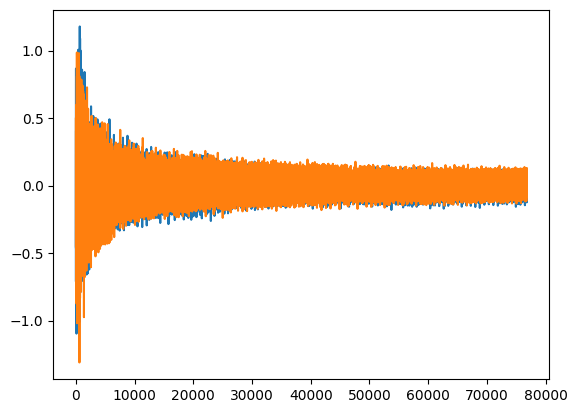

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1)
axs.plot(np.reshape(y_ours, (-1)))
axs.plot(np.reshape(y_theirs, -1))
plt.show()